In [13]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import traceback
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

# Helper class: Fetch Stock Data 

To Do List: 
* Get data within a specific range

In [4]:
class StockFetcher: 

    def __init__(self, ticker, market="SPY", start=None, end=None): 

        if isinstance(ticker, list): 
            self.ticker = ticker + [market]
        else: 
            self.ticker = [ticker, market]

        if market: 
            self.market = market
        else: 
            self.market = 'SPY'
            
        if not start: 
            self.start = datetime.today() - relativedelta(years=10)
            self.start = self.start.strftime("%Y-%m-%d")
            
    def get_stock_data(self): 
        try: 
            data = yf.download(tickers=self.ticker, start=self.start)
            return data
        except Exception as e: 
            print(f'Exception found: {e}')
            traceback.print_exc()

# Helper Class: Performs Regression Analysis 

To Do List: 
* Determine whether other algorithms are better in approximating the relationship between a stock and the market 
    * Time series to find the coefficients
    * Simple feed forward neural network 

In [30]:
class StockAnalysis: 

    def __init__(self, ticker, market="SPY", dollars=10000, start=None, end=None): 

        self.ticker = ticker
        
        if market: 
            self.market = market
        else: 
            self.market = 'SPY'
            
        self.start = start 
        self.end = end 
        self.dollars = dollars
        self.dollar_beta = 0
        self.nmv = self.__calculate_nmv()

        self.ticker_data = {} 

    def __fetch_data(self): 
        sf = StockFetcher(ticker=self.ticker, market=self.market, start=self.start, end=self.end)
        self.data = sf.get_stock_data()
    
    def __perform_regression(self): 
        returns = self.data['Adj Close'].pct_change()
        returns.columns = pd.MultiIndex.from_product([['Returns'], returns.columns])
        returns.dropna(inplace=True)
        
        assets = returns.drop(('Returns', 'SPY'), axis=1)
        market = returns[('Returns', 'SPY')]

        market_mean = market.mean()

        for col in assets.columns: 
            _, ticker = col 

            # Linear Regression 
            X = market 
            X = sm.add_constant(X)
            y = assets[col]

            model = sm.OLS(y, X).fit()
            alpha, beta = model.params

            # Caclulating the expected return 
            expected_returns = alpha + beta * market_mean 

            # Caclulating idiosyncratic volatility 
            idiosync_noise = model.resid

            # Setting the ticker data 
            self.ticker_data[ticker] = { 
                'alpha': alpha,
                'beta': beta,
                'idiosync_noise': idiosync_noise, 
                'nmv': self.nmv,
                'expected_returns': expected_returns, 
                'volatility': y.std()
            }
    
    def __calculate_nmv(self):
        return self.dollars / len(self.ticker)
    
    def __get_actual_performance(self): 
        
        actual_results = pd.Series(0, index=self.data.index)

        for ticker in self.ticker: 
            returns = self.data[('Adj Close', ticker)].pct_change()
            returns.iloc[0] = self.nmv
            returns[1:] += 1
            actual_results += returns.cumprod()

        return actual_results

    def __plot_performance(self, portfolio_results, market_results, actual_results):

        port_final = portfolio_results.iloc[-1]
        mkt_final = market_results.iloc[-1]
        actual_final = actual_results.iloc[-1]

        port_return = round(((port_final - self.dollars) / self.dollars) * 100, 3)
        mkt_return = round(((mkt_final - self.dollars) / self.dollars) * 100, 3)
        actual_return = round(((actual_final - self.dollars) / self.dollars) * 100, 3)


        plt.figure(figsize=(10, 6))
        plt.plot(portfolio_results.index, portfolio_results, label=f'Portfolio Value - {port_return}% Return', color='blue')
        plt.plot(market_results.index, market_results, label=f'Market Value (Benchmark) - {mkt_return}% Return', color='red')
        plt.plot(actual_results.index, actual_results, label=f'Actual Value - {actual_return}% Return', color='green')
        
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.yscale('log')
        plt.title('Portfolio vs Market Performance')
        plt.legend()
        plt.grid(True)

        plt.show()

    def __calculate_pnl(self): 
        m = self.data[('Adj Close', self.market)].pct_change()

        dollar_beta = 0 
        idio_contribution = 0

        for ticker in self.ticker_data: 
            beta = self.ticker_data[ticker]['beta']
            nmv = self.ticker_data[ticker]['nmv']
            idiosync_noise = self.ticker_data[ticker]['idiosync_noise']
            
            dollar_beta += beta * nmv
            idio_contribution +=  idiosync_noise * nmv 

        self.dollar_beta = dollar_beta
        pnl = dollar_beta * m + idio_contribution
        pnl.iloc[0] = self.dollars
        m.iloc[0] = self.dollars
        m[1:] += 1 

        portfolio_results = pnl.cumsum()  
        market_results = m.cumprod()
        actual_results = self.__get_actual_performance()

        self.__plot_performance(portfolio_results, market_results, actual_results)
    
    def __get_metrics(self): 
        market_vol = self.data[('Adj Close', self.market)].pct_change().std()
        portfolio_market_vol = self.dollar_beta * market_vol
        portfolio_idio_var = 0 

        for ticker in self.ticker: 
            portfolio_idio_var += (self.nmv * self.ticker_data[ticker]['volatility'])**2 
        
        portfolio_idio_vol = np.sqrt(portfolio_idio_var)

        total_vol = np.sqrt(portfolio_market_vol**2 + portfolio_idio_vol**2)

        print(f'Portfolio Idio Volatility: {portfolio_idio_vol}')
        print(f'Portfolio Market Volatility: {portfolio_market_vol}')
        print(f'Portfolio Total Volatility: {total_vol}')

    def perform_analysis(self): 
        self.__fetch_data() 
        self.__perform_regression() 
        self.__get_metrics()
        self.__calculate_pnl() 

[*********************100%%**********************]  5 of 5 completed


Portfolio Idio Volatility: 110.918313137694
Portfolio Market Volatility: 0.0
Portfolio Total Volatility: 110.918313137694


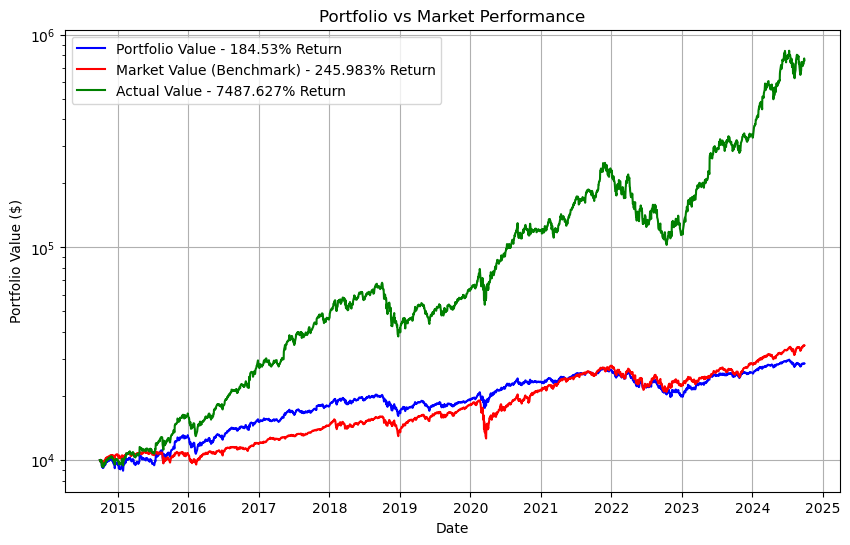

In [31]:
ticker = ['GOOG', 'AMZN', 'NVDA', 'MSFT']
sa = StockAnalysis(ticker=ticker)
sa.perform_analysis()